## Lab 7.4 — Grad-CAM (Explainable AI for Digital Health)

In this lab, you will use Grad-CAM to generate heatmaps that highlight the important regions of an image influencing the model’s predictions. In this example, we apply Grad-CAM to a skin cancer classification task.



## Setup

In [1]:
!pip install pytorch-lightning
!pip install torchinfo
!pip install -U scikit-learn
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=3853aa967774de530df21c2a692106a876c1c3d241a6b0619276d0ba8f695bea
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
import os
import cv2
import random
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from random import randint
from typing import NewType

# pytorch libraries
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import Accuracy
import pytorch_lightning as pl
import torchvision.models as models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

## Download data, model

In [3]:
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
!unzip -q -o 'Ham10000_torch.zip'

!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class07_ASR%26FaceRecognition/efficientnetv2_polyp.zip -O repo.zip
!unzip -q -o 'repo.zip'

--2026-01-17 07:10:10--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip [following]
--2026-01-17 07:10:11--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94841947 (90M) [application/zip]
Saving to: ‘Ham10000_torch.zip’

Ham10000_torch.zip  100%[===================>]  90.45M  64.1MB/s    in 1.4s    

2026-01-17 07:10:12 (64.1 M

In [4]:
df=pd.read_csv('GroundTruth.csv')
df['image']=df['image'].apply(lambda x: x+ '.jpg')
df = df.drop(columns=["Unnamed: 0"])

In [5]:
# Set dataset format
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis like lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}
labels = list(df.columns[1:])
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=lesion_type_dict[labels[index]]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
df['label_idx'] = pd.Categorical(df['label']).codes

In [6]:
# Split dataset
test_df = df[280:350]

test_df = test_df.reset_index(drop=True)

print('Data Len Test:', len(test_df))

Data Len Test: 70


In [7]:
# Set transform (preprocessing)
val_transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

In [8]:
# Dataset object
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(os.path.join('images', self.df['image'][index]))
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

test_set = HAM10000(test_df, transform=val_transform)
test_loader = DataLoader(test_set, batch_size=7, shuffle=False, num_workers=10)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Load model

In [9]:
# Create model & set loss function
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=7, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetV2 model from torchvision
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
        # Replace the classifier with a custom layer for our task
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = LitEfficientNetV2.load_from_checkpoint("efficientnetv2-polyp.ckpt").to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 149MB/s]


testing ...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipython-input-843888826.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = inputs[j].cpu()*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean().numpy()     # unnormalize
100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


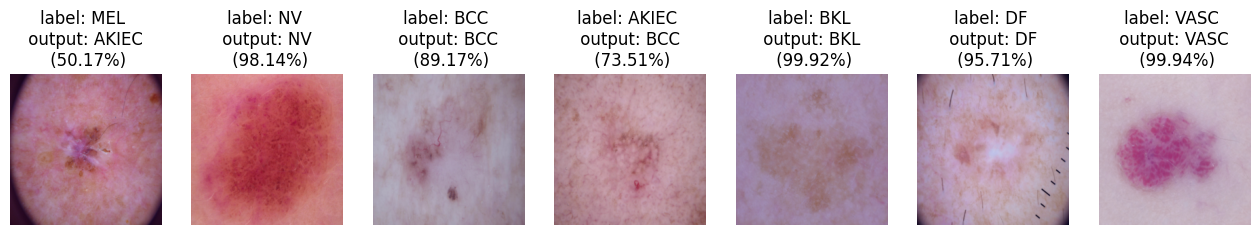

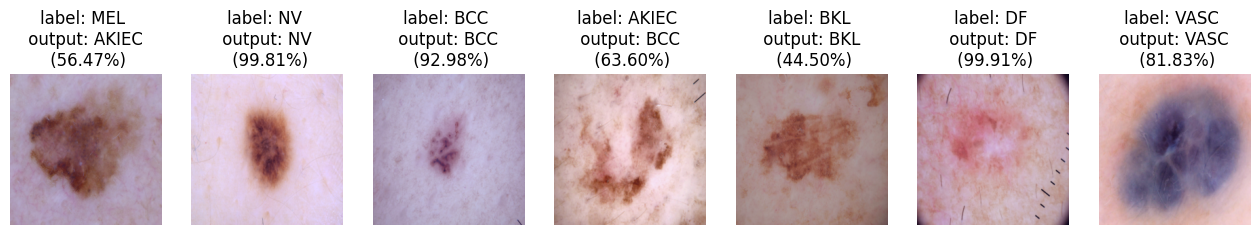

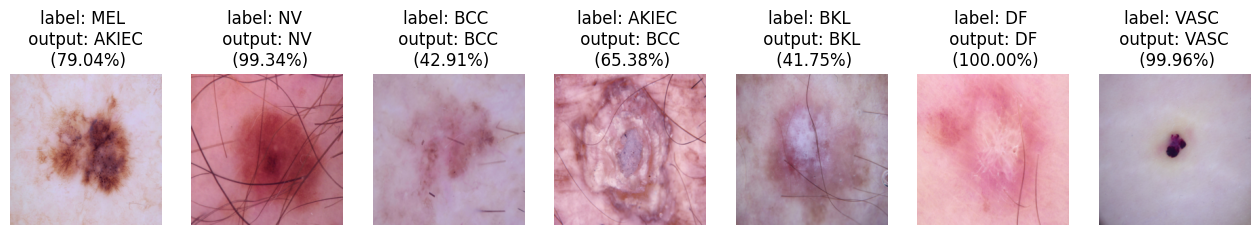

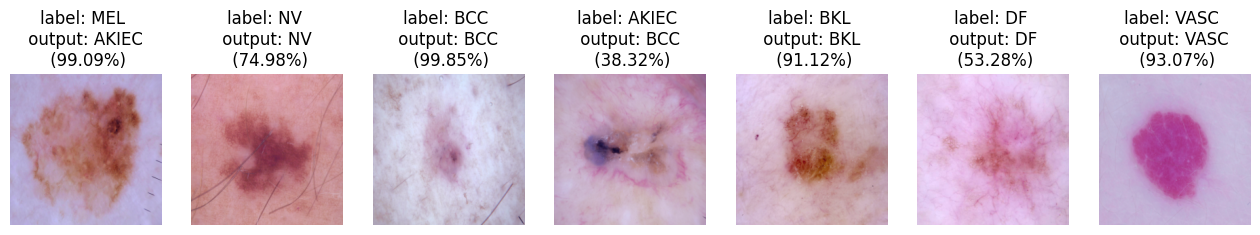

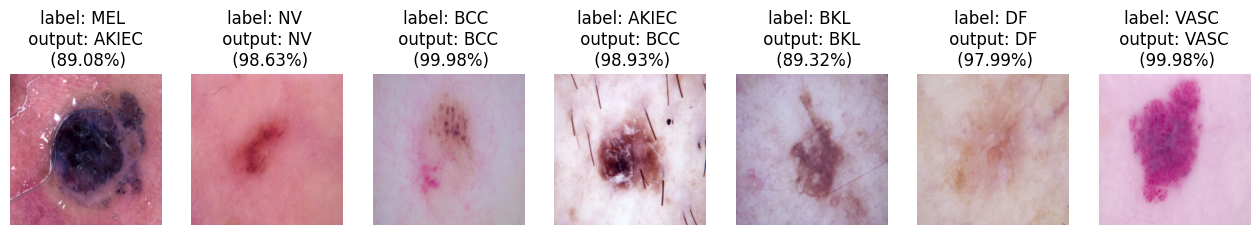

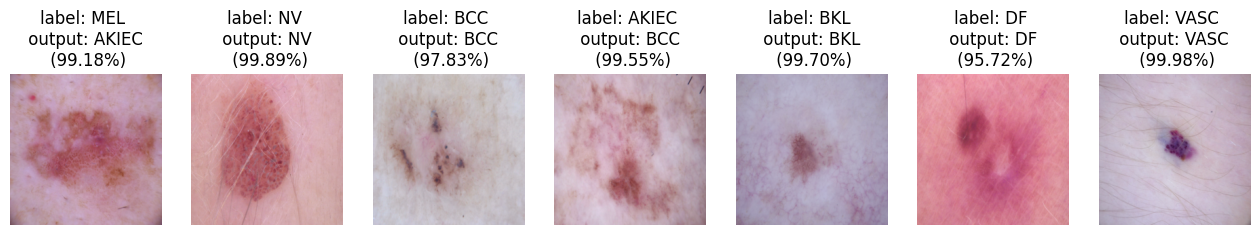

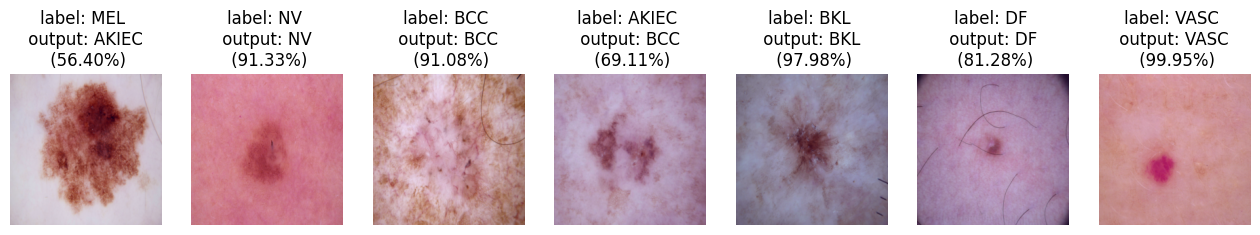

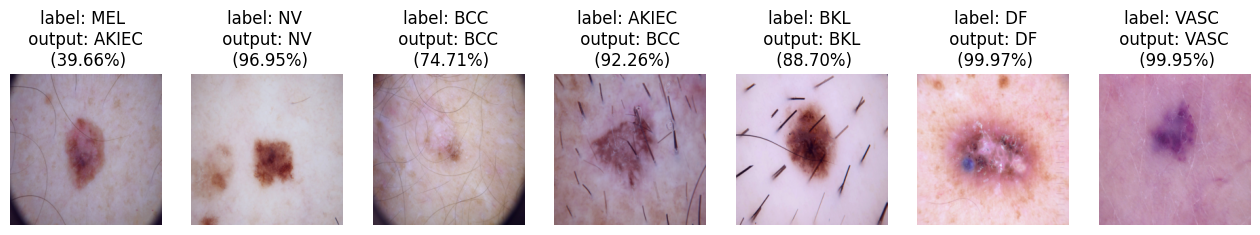

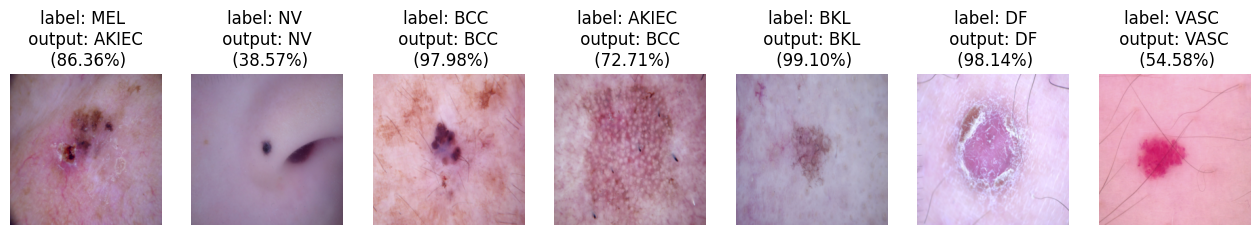

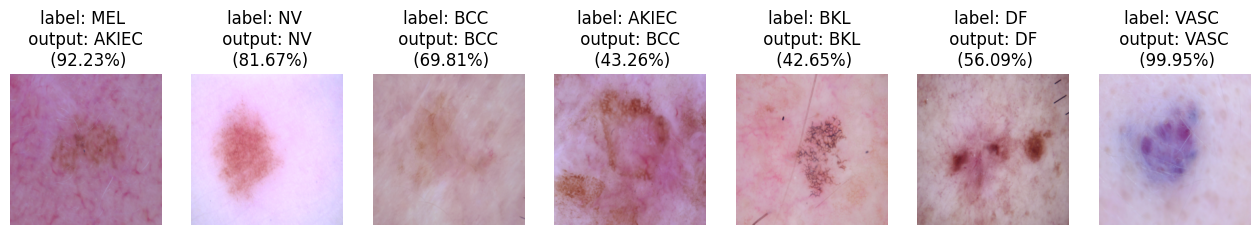

In [10]:
# Inference in test dataset
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'NV', 'MEL', 'VASC']
criterion = nn.CrossEntropyLoss()
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())
        n+=1

        plt.figure(figsize=(16, 14))
        for j in range(7):
          plt.subplot(1,7,j+1)
          img = inputs[j].cpu()*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean().numpy()     # unnormalize
          img = np.clip(img, 0, 1)
          plt.imshow(np.transpose(img, (1, 2, 0)))
          plt.axis("off")
          plt.title(f"label: {class_names[labels[j].cpu()]} \n output: {class_names[y_predict[j]]} \n ({y_probs[j][np.argmax(y_probs[j])]*100:.2f}%)")

## Grad-CAM

The step wise process to generate CAMs are as follows:

1. First, one needs to decide for which class and convolutional layer in the neural network the CAM is to be generated.

2. Then, calculate the activations simply by passing the input to the convolutional layer.

3. Fetch the gradient values from the same layer with respect to the class.

4. Calculate the mean of the gradients within each output channel.

5. Calculate the weighted activation map and then compute mean.

6. Upscale the weighted activation map outputs to the same size as the input of the image.

7. Finally, overlay the activation map onto the input image.



### Example image



Label: 6


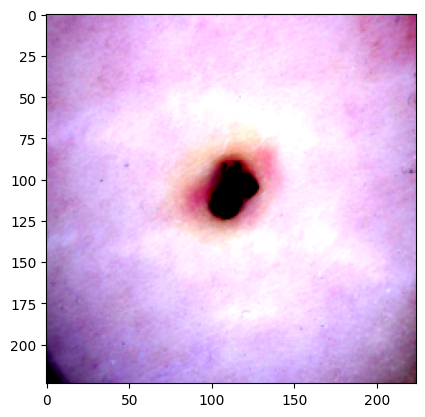

In [11]:
npimg = np.clip(test_set[20][0].cpu().numpy(), 0, 1)
plt.imshow(np.transpose(npimg, (1, 2, 0)))
print(f"Label: {test_set[20][1]}")

In [13]:
target_layer = net.model.features[-1]
cam = GradCAM(model=net, target_layers=[target_layer])
# Prepare image for visualization
img_np = test_set[20][0].permute(1, 2, 0).cpu().numpy()
img = (img_np - img_np.min()) / (img_np.max() - img_np.min())
targets = None   # default None = Use the prediction chosen by the model (top-1).
input_tensor = test_set[20][0].unsqueeze(0).to(device)

Text(0.5, 1.0, 'Grad-CAM Result')

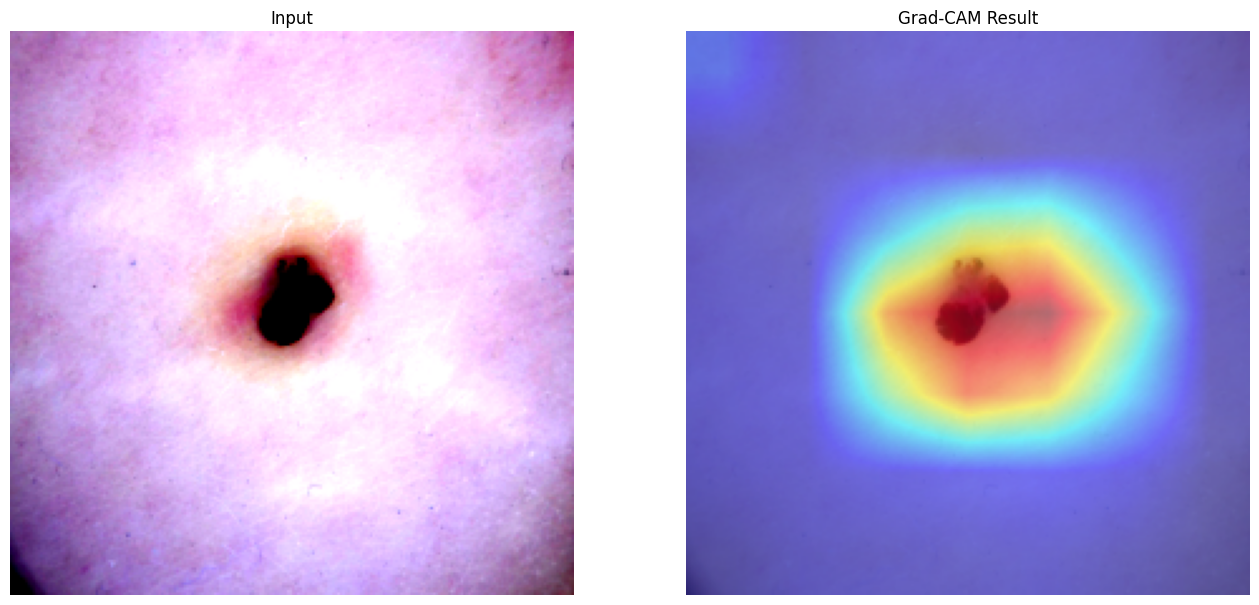

In [15]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Overlay heatmap
visualization = show_cam_on_image(img, grayscale_cam[0, :], use_rgb=True)
cv2.imwrite("gradcam_result.jpg", visualization)

plt.figure(figsize=(16, 14))
plt.subplot(1,2,1)
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis("off")
plt.title("Input")

plt.subplot(1,2,2)
plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Result")